# 基金组合回测

### 导入包，登录

In [1]:
from jqdatasdk import *
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# 登录，需要在聚宽注册账号并申请数据权限，免费一年
auth('','')

auth success 


### 准备基金代码列表

In [3]:
code_list = '519736,163402,163406,007119,161005,519712,206018,000948'.split(',')

### 函数定义

In [4]:
def get_data(code, limit=100):
    '获取某基金最近的单位净值数据'
    q = query(finance.FUND_NET_VALUE.day,finance.FUND_NET_VALUE.net_value)
    q = q.filter(finance.FUND_NET_VALUE.code==code)
    q = q.order_by(finance.FUND_NET_VALUE.day.desc()).limit(limit)
    df = finance.run_query(q)
    df.rename(columns={'net_value': code}, inplace=True) 
    df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')
    return df.set_index('day')

In [5]:
def get_all_data(code_list, limit=100):
    '获取一组基金净值数据'
    ret  = None
    for code in code_list:
        df = get_data(code, limit)
        if ret is not None:
            ret = pd.merge(ret, df, on='day')
        else:
            ret = df
    return ret

In [6]:
def abs_return_pcnt(series):
    '绝对回报率'
    return (series.iloc[-1] - series.iloc[0]) / series.iloc[0]

def sharpe_ratio(series, freq='daily'):
    '夏普比率'
    r = series / series.shift(1) - 1
    r = r.dropna()
    if freq == 'daily':
        sr = r.mean() / r.std() * np.sqrt(252)
    elif freq == 'monthly':
        sr = r.mean() / r.std() * np.sqrt(12)
    else:
        sr = r.mean() / r.std()
    return sr

def maximum_drawdown(series):
    '最大回撤'
    performance_list = list(series)
    i = np.argmax(np.maximum.accumulate(performance_list) - performance_list)
    j = np.argmax(performance_list[:i])
    mdd = (performance_list[i] - performance_list[j]) / performance_list[j]
    return mdd

### 获取数据，查看净值曲线

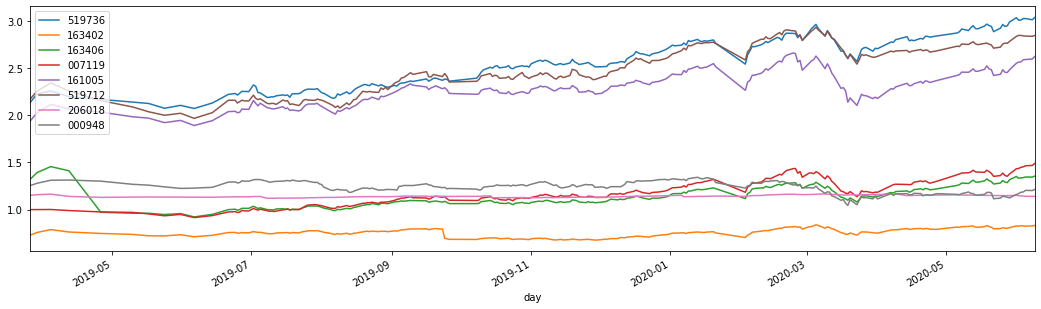

In [7]:
df=get_all_data(code_list,500)
df = df.sort_index()
df.plot(figsize=[18,5])

### 计算组合净值曲线、5 日均线

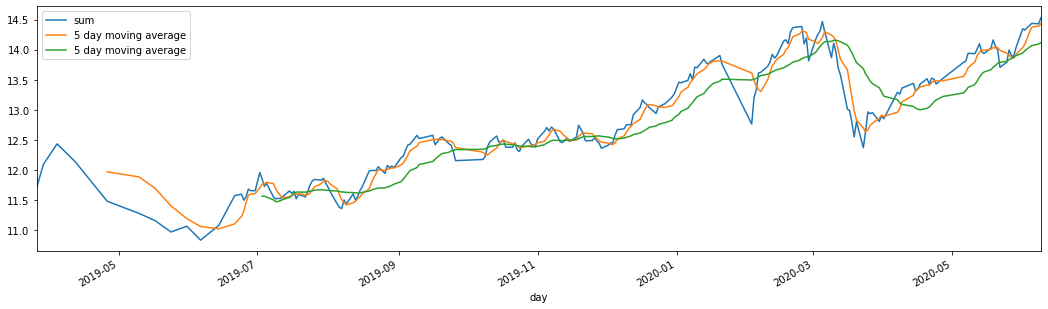

In [8]:
df['sum'] = df.apply(lambda x: sum(x[str(code)] for code in code_list) , axis=1)
df.plot(y='sum', figsize=(18,5))
df['sum'].rolling(5).mean().plot(label='5 day moving average')
df['sum'].rolling(20).mean().plot(label='5 day moving average')
plt.legend()

### 计算绝对收益，最大回撤，夏普率

In [9]:
print("绝对收益: " + "{0:.2f}".format(abs_return_pcnt(df['sum'])*100) + "%")

绝对收益: 24.15%


In [10]:
print(" 最大回撤: " + "{0:.2f}".format(maximum_drawdown(df['sum'])*100) + "%")

 最大回撤: -14.48%


In [11]:
print(" 夏普比率: " + "{0:.2f}".format(sharpe_ratio(df['sum'], freq='yearly')))

 夏普比率: 0.08


### 计算日收益波动

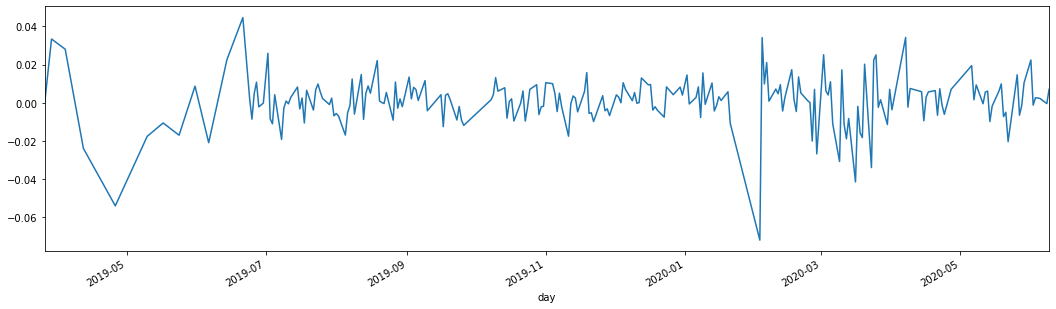

In [12]:
# 日收益率
daily = df.pct_change()
daily.fillna(0, inplace=True)
plt.figure(figsize=[18,5])
daily['sum'].plot()

In [13]:
# 数据摘要，查看平均值和标准差
daily['sum'].describe()

count    232.000000
mean       0.001015
std        0.012786
min       -0.071902
25%       -0.004551
50%        0.001669
75%        0.007041
max        0.044633
Name: sum, dtype: float64

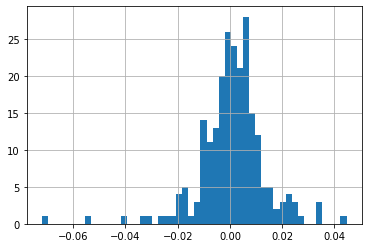

In [14]:
# 直方图
daily['sum'].hist(bins=50)

### 计算日，月，季度累计收益

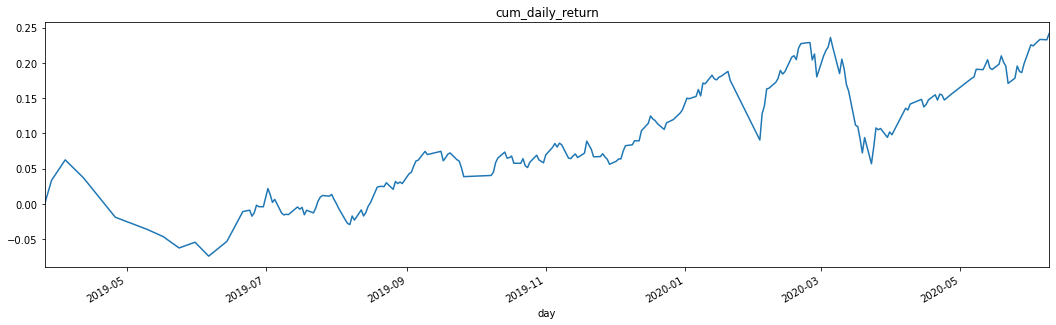

In [15]:
#计算累积日收益率
cum_daily_return = (1 + daily['sum']).cumprod()-1
cum_daily_return.plot(figsize=(18,5))
plt.title('cum_daily_return')
plt.show()

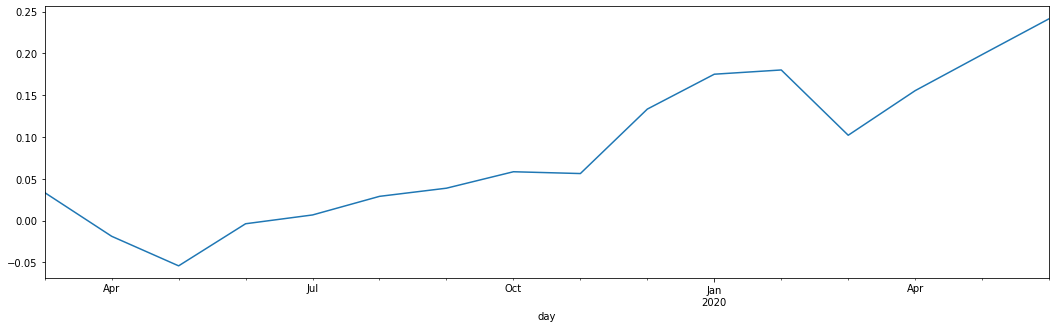

In [16]:
# 月收益率，取每月最后一项
monthly = cum_daily_return.resample('BM').apply(lambda x: x[-1])
plt.figure(figsize=[18,5])
monthly.plot()

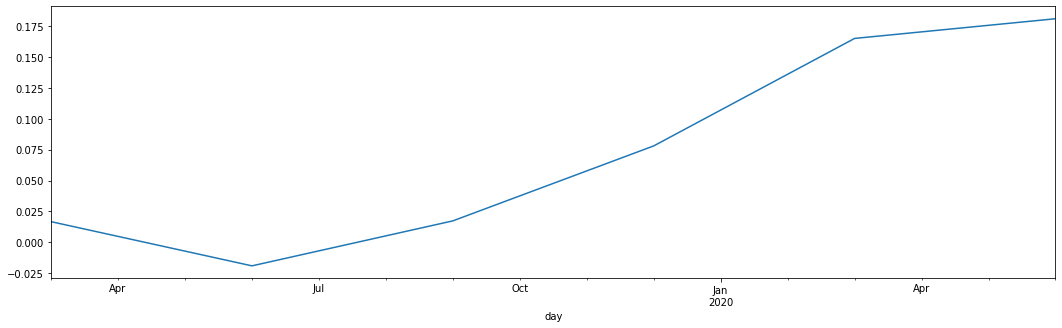

In [17]:
#按季度对数据进行重采样，将均值改为每季度的数值
quarter = cum_daily_return.resample('3M').mean()
plt.figure(figsize=[18,5])
quarter.plot()

### 按月、年分组查看数据

In [18]:
monthly_df = df.groupby([df.index.year, df.index.month]).median()
monthly_df

519736   163402   163406   007119   161005  519712  206018   000948  \
day  day                                                                        
2019 3    2.1805  0.74380  1.35725  1.00020  1.98290  2.2140  1.1550  1.26710   
     4    2.1970  0.76290  1.41170  0.99010  2.06580  2.2580  1.1400  1.31150   
     5    2.1150  0.72835  0.95975  0.95205  1.95750  2.0290  1.1330  1.25030   
     6    2.2310  0.75420  1.00090  0.97560  2.03860  2.1520  1.1350  1.29190   
     7    2.2330  0.75780  1.01000  1.00225  2.08385  2.1560  1.1230  1.30235   
     8    2.2730  0.76210  1.02530  1.04560  2.09995  2.1670  1.1355  1.20995   
     9    2.3620  0.78695  1.08665  1.12235  2.28885  2.4090  1.1415  1.24645   
     10   2.5095  0.69040  1.06890  1.11650  2.24080  2.4080  1.1260  1.25385   
     11   2.5520  0.68350  1.08370  1.14270  2.28170  2.4150  1.1290  1.26280   
     12   2.6140  0.70910  1.11595  1.17530  2.33215  2.5445  1.1400  1.29135   
2020 1    2.7810  0.75650  1.20440  1.27630  2.49570  2.7505  1.1410  1.32580   
     2    2.7895  0.78825  1.24205  1.33785  2.49525  2.8225  1.1575  1.28395   
     3    2.7165  0.76380  1.14590  1.19790  2.28900  2.6990  1.1590  1.13605   
     4    2.8040  0.79215  1.20355  1.27480  2.33615  2.6815  1.1535  1.15740   
     5    2.9345  0.81375  1.29265  1.38720  2.46630  2.7550  1.1510  1.15985   
     6    3.0240  0.82720  1.34460  1.45350  2.58730  2.8410  1.1440  1.18680   

               sum  
day  day            
2019 3    11.90075  
     4    12.13910  
     5    11.11680  
     6    11.57840  
     7    11.65130  
     8    11.72025  
     9    12.42645  
     10   12.40325  
     11   12.53400  
     12   12.93015  
2020 1    13.73215  
     2    13.90970  
     3    13.00100  
     4    13.42900  
     5    13.94990  
     6    14.40190

In [19]:
yearly_df = df.groupby([df.index.year]).median()
yearly_df

,519736,163402,163406,007119,161005,519712,206018,000948,sum
day,,,,,,,,,
2019,2.361,0.7372,1.0694,1.1023,2.2311,2.379,1.134,1.2573,12.3309
2020,2.815,0.7973,1.2259,1.3127,2.4658,2.760,1.153,1.1839,13.7914


### 计算各基金相关度

In [20]:
# 调用 Pandas 的 pct_change() 方法来计算每月的回报百分比，并且把第一月设为0.
monthly_ret_df = monthly_df.pct_change(1).fillna(0)
# 画出各基金回报率的相关性，并且把相关性数据精度设为3.
monthly_ret_df.corr().style.background_gradient().set_precision(3)

,519736,163402,163406,007119,161005,519712,206018,000948,sum
519736,1,0.197,0.701,0.681,0.685,0.732,-0.034,0.64,0.815
163402,0.197,1,0.552,0.605,0.657,0.598,0.457,0.366,0.643
163406,0.701,0.552,1,0.655,0.725,0.815,0.194,0.527,0.889
007119,0.681,0.605,0.655,1,0.849,0.684,0.241,0.607,0.851
161005,0.685,0.657,0.725,0.849,1,0.852,0.0592,0.795,0.928
519712,0.732,0.598,0.815,0.684,0.852,1,0.322,0.629,0.916
206018,-0.034,0.457,0.194,0.241,0.0592,0.322,1,-0.288,0.172
000948,0.64,0.366,0.527,0.607,0.795,0.629,-0.288,1,0.764
sum,0.815,0.643,0.889,0.851,0.928,0.916,0.172,0.764,1


### 收益排序

In [21]:
# 先对每一个回报率 +1，然后做 cumprod() 计算，Pandas 的 cumprod() 对每一行做滚动计算累积盈利。#
monthly_cum_ret_df = monthly_ret_df.add(1).cumprod()
# 对 2020-05 月的累积盈利做一个各基金的排名，利用 sort_values()。
monthly_cum_ret_df.loc[2020,5].sort_values(ascending=False)

007119    1.386923
519736    1.345792
519712    1.244354
161005    1.243784
sum       1.172187
163402    1.094044
206018    0.996537
163406    0.952404
000948    0.915358
Name: (2020, 5), dtype: float64

### 最优化仓位训练

一个投资组合所持有的风险，不一定能带来最大化的收益。换句话说，你的投资组合也许承担了较大的风险，却只能获得较小的预期收益。原因可能在于你过大的权重了一只表现较差的股票，或者投资组合里的股票数量少，并且每一只股票都自带非常大的风险。

最优投资组合是建立在一条叫 有效边际 Efficient Frontier 之上的，

In [38]:
num_stocks = len(code_list)

In [39]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    '夏普率'
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    '波动率'
    results = np.zeros((num_stocks,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev #波动率目标
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev # 夏普比率目标
    return results, weights_record

In [56]:
all_df = df[code_list]
# 每只基金的日回报百分比。
returns = all_df[code_list].pct_change()
# 每只基金的日回报百分比平均
mean_returns = returns.mean()
# 每只股票的日回报百分比协方差。
cov_matrix = returns.cov()
# 想要生成多少个随机投资组合，数字越大越接近真实的最优解，但是也会消耗CPU资源。
num_portfolios = int(25000 / 2.5 * num_stocks)
# 无风险利率
risk_free_rate = 0.027

In [60]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    '最优化方法'
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=all_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=all_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("最大夏普比率投资组合配置\n")
    print("年化收益:", round(rp,2))
    print("年化波动:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("最小波动率投资组合配置\n")
    print("年华收益:", round(rp_min,2))
    print("年化波动:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    
    return max_sharpe_allocation, min_vol_allocation

--------------------------------------------------------------------------------
最大夏普比率投资组合配置

年化收益: 0.39
年化波动: 0.22


            519736  163402  163406  007119  161005  519712  206018  000948
allocation   44.47    4.27    1.98   31.32    3.86   13.06    0.03     1.0
--------------------------------------------------------------------------------
最小波动率投资组合配置

年华收益: 0.12
年化波动: 0.12


            519736  163402  163406  007119  161005  519712  206018  000948
allocation    3.34    5.99     1.1    0.02    11.9   19.28    48.4    9.96


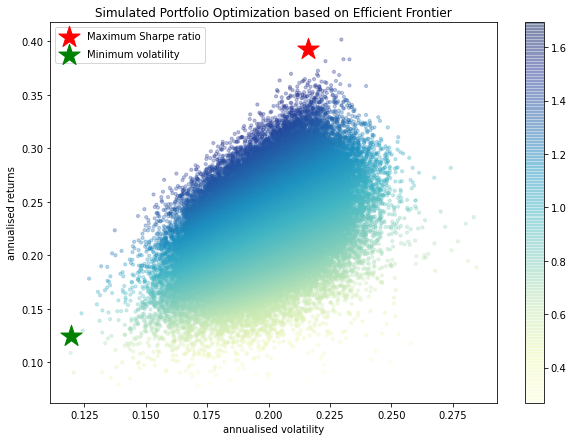

In [61]:
max_sharpe_alloc, min_vol_alloc = display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

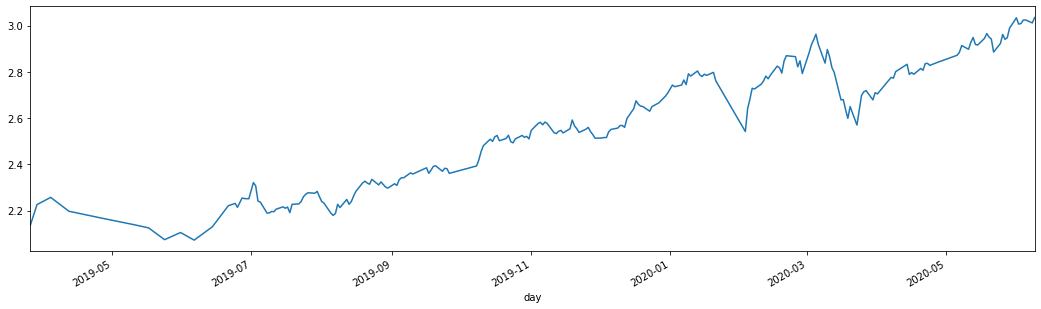

In [69]:
df['519736'].plot(figsize=[18,5])